In [1]:
import sys
sys.path.append("..")  

In [2]:
import json
import pickle
from pathlib import Path

import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader


from utils.dataloader import get_transforms, load_split_ids, build_caption_dataset
from utils.caption_dataset import CaptionDataset

In [3]:
# Load vocabulary
with open("../data/processed/word2idx.json", "r") as f:
    word2idx = json.load(f)

# Load image-caption sequences (already tokenized and cleaned)
with open("../data/processed/image_caption_seqs.pkl", "rb") as f:
    image_caption_seqs = pickle.load(f)

In [4]:
# Load official splits
train_ids = load_split_ids("../data/Flickr8k_text/Flickr_8k.trainImages.txt")
val_ids   = load_split_ids("../data/Flickr8k_text/Flickr_8k.devImages.txt")
test_ids  = load_split_ids("../data/Flickr8k_text/Flickr_8k.testImages.txt")

In [5]:
# Set image folder path
image_folder = "../data/Flicker8k_Dataset"

# Define transforms
transform_train = get_transforms("train")
transform_val   = get_transforms("val")

# Build datasets using shared util function
train_dataset = build_caption_dataset(train_ids, image_caption_seqs, word2idx, image_folder, transform_train)
val_dataset   = build_caption_dataset(val_ids, image_caption_seqs, word2idx, image_folder, transform_val)
test_dataset  = build_caption_dataset(test_ids, image_caption_seqs, word2idx, image_folder, transform_val)

In [6]:
class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=14, fine_tune=True):
        super(EncoderCNN, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = models.resnet101(pretrained=True)
        # Remove linear and pooling layers (classifier)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Adaptive pooling to ensure fixed size output
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune(fine_tune)

    def forward(self, images):
        out = self.resnet(images)               # (batch_size, 2048, H, W)
        out = self.adaptive_pool(out)           # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)           # (batch_size, enc_size, enc_size, 2048)
        return out

    def fine_tune(self, fine_tune=True):
        for p in self.resnet.parameters():
            p.requires_grad = False

        # Unfreeze layer4 and onwards for fine-tuning
        if fine_tune:
            for c in list(self.resnet.children())[5:]:
                for p in c.parameters():
                    p.requires_grad = True

In [7]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, hidden_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(hidden_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        """
        encoder_out: (batch_size, num_pixels, encoder_dim)
        decoder_hidden: (batch_size, hidden_dim)
        """
        att1 = self.encoder_att(encoder_out)       # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)  # (batch_size, 1, attention_dim)
        att = self.full_att(self.relu(att1 + att2)).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)                  # (batch_size, num_pixels)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)
        return context, alpha

In [8]:
class DecoderRNNWithAttention(nn.Module):
    def __init__(self, attention_dim, embed_dim, hidden_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(DecoderRNNWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        self.attention = Attention(encoder_dim, hidden_dim, attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout_layer = nn.Dropout(p=dropout)

        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, hidden_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, hidden_dim)
        self.init_c = nn.Linear(encoder_dim, hidden_dim)

        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, encoder_out, captions):
        """
        encoder_out: (batch_size, enc_size, enc_size, encoder_dim)
        captions: (batch_size, max_len)
        """
        batch_size = captions.size(0)
        vocab_size = self.vocab_size
        max_len = captions.size(1)

        # Flatten spatial features
        encoder_out = encoder_out.view(batch_size, -1, self.encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        embeddings = self.embedding(captions)  # (batch_size, max_len, embed_dim)

        h, c = self.init_hidden_state(encoder_out.mean(dim=1))  # init with mean-pooled image

        outputs = torch.zeros(batch_size, max_len, vocab_size).to(captions.device)

        for t in range(max_len):
            context, _ = self.attention(encoder_out, h)
            lstm_input = torch.cat([embeddings[:, t, :], context], dim=1)
            h, c = self.decode_step(lstm_input, (h, c))
            preds = self.fc(self.dropout_layer(h))
            outputs[:, t, :] = preds

        return outputs

    def init_hidden_state(self, mean_encoder_out):
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

In [9]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

def train_model(model, train_dataset, val_dataset, word2idx, device='cuda', 
                batch_size=32, epochs=20, patience=3, lr=1e-4):
    from torch.utils.data import DataLoader
    import torch.nn as nn
    import numpy as np
    import torch

    pad_idx = word2idx['<pad>']
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=2, factor=0.5
)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_losses = []

        tqdm_train = tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]")
        for images, captions, _ in tqdm_train:
            images, captions = images.to(device), captions.to(device)

            optimizer.zero_grad()
            outputs = model(images, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), captions[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            tqdm_train.set_postfix(loss=np.mean(train_losses))

        avg_train_loss = np.mean(train_losses)

        # Validation
        model.eval()
        val_losses = []
        references = []
        hypotheses = []

        tqdm_val = tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]")
        with torch.no_grad():
            for images, captions, lengths in tqdm_val:
                images, captions = images.to(device), captions.to(device)
                outputs = model(images, captions[:, :-1])
                loss = criterion(outputs.reshape(-1, outputs.size(-1)), captions[:, 1:].reshape(-1))
                val_losses.append(loss.item())

                # BLEU prep
                preds = torch.argmax(outputs, dim=2)
                for ref, pred in zip(captions, preds):
                    ref_tokens = [w for w in ref.tolist() if w not in {pad_idx, word2idx['<start>'], word2idx['<end>']}]
                    pred_tokens = [w for w in pred.tolist() if w not in {pad_idx, word2idx['<start>'], word2idx['<end>']}]
                    references.append([ref_tokens])
                    hypotheses.append(pred_tokens)

        avg_val_loss = np.mean(val_losses)
        scheduler.step(avg_val_loss)

        bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
        bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
        bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
        bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

        print(f"\nEpoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        print(f"BLEU-1 = {bleu1:.4f}, BLEU-2 = {bleu2:.4f}, BLEU-3 = {bleu3:.4f}, BLEU-4 = {bleu4:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    print("Training complete.")
    return model

In [10]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [11]:
class CaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(CaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        encoder_out = self.encoder(images)
        outputs = self.decoder(encoder_out, captions)
        return outputs

In [ ]:
# # Step 1: Set hyperparameters
# embed_dim = 256
# hidden_dim = 512
# attention_dim = 256
# dropout = 0.5
# vocab_size = len(word2idx)

# # Step 2: Instantiate encoder and decoder
# encoder = EncoderCNN(encoded_image_size=14, fine_tune=True)
# decoder = DecoderRNNWithAttention(
#     attention_dim=attention_dim,
#     embed_dim=embed_dim,
#     hidden_dim=hidden_dim,
#     vocab_size=vocab_size,
#     encoder_dim=2048,
#     dropout=dropout
# )

# # Step 3: Wrap into model
# model = CaptioningModel(encoder, decoder).to(device)

# # Step 4: Train the model
# trained_model = train_model(
#     model=model,
#     train_dataset=train_dataset,
#     val_dataset=val_dataset,
#     word2idx=word2idx,
#     device=device,
#     batch_size=8,
#     epochs=20,
#     patience=3,
#     lr=1e-4
# )

Epoch 1 [Validation]: 100%|██████████| 625/625 [01:37<00:00,  6.41it/s]



Epoch 1: Train Loss = 4.1693, Val Loss = 3.6511
BLEU-1 = 0.3213, BLEU-2 = 0.1658, BLEU-3 = 0.0885, BLEU-4 = 0.0470


Epoch 2 [Validation]: 100%|██████████| 625/625 [01:35<00:00,  6.52it/s]



Epoch 2: Train Loss = 3.4759, Val Loss = 3.3423
BLEU-1 = 0.3516, BLEU-2 = 0.1890, BLEU-3 = 0.1047, BLEU-4 = 0.0575


Epoch 3 [Validation]: 100%|██████████| 625/625 [01:40<00:00,  6.21it/s]



Epoch 3: Train Loss = 3.2002, Val Loss = 3.1870
BLEU-1 = 0.3692, BLEU-2 = 0.2015, BLEU-3 = 0.1130, BLEU-4 = 0.0631


Epoch 4 [Validation]: 100%|██████████| 625/625 [01:38<00:00,  6.35it/s]



Epoch 4: Train Loss = 3.0214, Val Loss = 3.0859
BLEU-1 = 0.3832, BLEU-2 = 0.2136, BLEU-3 = 0.1227, BLEU-4 = 0.0689


Epoch 5 [Validation]: 100%|██████████| 625/625 [01:35<00:00,  6.53it/s]



Epoch 5: Train Loss = 2.8861, Val Loss = 3.0114
BLEU-1 = 0.3897, BLEU-2 = 0.2206, BLEU-3 = 0.1289, BLEU-4 = 0.0727


Epoch 6 [Validation]: 100%|██████████| 625/625 [01:36<00:00,  6.51it/s]



Epoch 6: Train Loss = 2.7734, Val Loss = 2.9563
BLEU-1 = 0.3923, BLEU-2 = 0.2209, BLEU-3 = 0.1291, BLEU-4 = 0.0726


Epoch 7 [Validation]: 100%|██████████| 625/625 [01:36<00:00,  6.45it/s]



Epoch 7: Train Loss = 2.6814, Val Loss = 2.9325
BLEU-1 = 0.3806, BLEU-2 = 0.2162, BLEU-3 = 0.1270, BLEU-4 = 0.0713


Epoch 8 [Validation]: 100%|██████████| 625/625 [01:36<00:00,  6.48it/s]



Epoch 8: Train Loss = 2.5981, Val Loss = 2.9032
BLEU-1 = 0.4048, BLEU-2 = 0.2324, BLEU-3 = 0.1386, BLEU-4 = 0.0810


Epoch 9 [Validation]: 100%|██████████| 625/625 [01:37<00:00,  6.44it/s]



Epoch 9: Train Loss = 2.5228, Val Loss = 2.8905
BLEU-1 = 0.4049, BLEU-2 = 0.2337, BLEU-3 = 0.1388, BLEU-4 = 0.0805


Epoch 10 [Validation]: 100%|██████████| 625/625 [01:36<00:00,  6.50it/s]



Epoch 10: Train Loss = 2.4570, Val Loss = 2.8565
BLEU-1 = 0.4088, BLEU-2 = 0.2363, BLEU-3 = 0.1415, BLEU-4 = 0.0817


Epoch 11 [Validation]: 100%|██████████| 625/625 [01:35<00:00,  6.53it/s]



Epoch 11: Train Loss = 2.3935, Val Loss = 2.8507
BLEU-1 = 0.4130, BLEU-2 = 0.2401, BLEU-3 = 0.1455, BLEU-4 = 0.0857


Epoch 12 [Validation]: 100%|██████████| 625/625 [01:36<00:00,  6.49it/s]



Epoch 12: Train Loss = 2.3376, Val Loss = 2.8476
BLEU-1 = 0.4085, BLEU-2 = 0.2364, BLEU-3 = 0.1415, BLEU-4 = 0.0829


Epoch 13 [Validation]: 100%|██████████| 625/625 [01:36<00:00,  6.47it/s]



Epoch 13: Train Loss = 2.2791, Val Loss = 2.8478
BLEU-1 = 0.4149, BLEU-2 = 0.2423, BLEU-3 = 0.1476, BLEU-4 = 0.0873


Epoch 14 [Validation]: 100%|██████████| 625/625 [01:36<00:00,  6.49it/s]



Epoch 14: Train Loss = 2.2279, Val Loss = 2.8331
BLEU-1 = 0.4133, BLEU-2 = 0.2395, BLEU-3 = 0.1433, BLEU-4 = 0.0837


Epoch 15 [Validation]: 100%|██████████| 625/625 [01:35<00:00,  6.52it/s]



Epoch 15: Train Loss = 2.1785, Val Loss = 2.8393
BLEU-1 = 0.4102, BLEU-2 = 0.2383, BLEU-3 = 0.1441, BLEU-4 = 0.0844


Epoch 16 [Validation]: 100%|██████████| 625/625 [01:36<00:00,  6.48it/s]



Epoch 16: Train Loss = 2.1299, Val Loss = 2.8470
BLEU-1 = 0.4120, BLEU-2 = 0.2424, BLEU-3 = 0.1484, BLEU-4 = 0.0884


Epoch 17 [Validation]: 100%|██████████| 625/625 [01:39<00:00,  6.28it/s]



Epoch 17: Train Loss = 2.0851, Val Loss = 2.8442
BLEU-1 = 0.4088, BLEU-2 = 0.2380, BLEU-3 = 0.1439, BLEU-4 = 0.0844
Early stopping triggered at epoch 17
Training complete.


In [ ]:
# # Save trained model
# torch.save(model.state_dict(), "../data/experiment_camilo_model1.pth")


# torch.save(model, "../data/experiment_camilo_model1_full.pth")

In [22]:
# Ensure classes EncoderCNN, Attention, DecoderRNNWithAttention, and CaptioningModel are already defined

# Step 1: Set hyperparameters exactly as in training
embed_dim = 256
hidden_dim = 512
attention_dim = 256
dropout = 0.5
vocab_size = len(word2idx)

# Step 2: Instantiate encoder and decoder
encoder = EncoderCNN(encoded_image_size=14, fine_tune=True)
decoder = DecoderRNNWithAttention(
    attention_dim=attention_dim,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    encoder_dim=2048,
    dropout=dropout
)

# Step 3: Wrap into the full model
model = CaptioningModel(encoder, decoder).to(device)

# Step 4: Load trained weights
model_path = "../data/experiment_camilo_model1.pth"  
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

CaptioningModel(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)


In [28]:
from nltk.translate.bleu_score import corpus_bleu
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
import numpy as np
import torch.nn as nn

def evaluate_model_on_test(model, test_dataset, word2idx, device='cuda', batch_size=32):
    pad_idx = word2idx['<pad>']
    start_idx = word2idx['<start>']
    end_idx = word2idx['<end>']

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    model.eval()
    test_losses = []
    references = []
    hypotheses = []

    tqdm_test = tqdm(test_loader, desc="Evaluating [Test Set]")
    with torch.no_grad():
        for images, captions, _ in tqdm_test:
            images, captions = images.to(device), captions.to(device)

            outputs = model(images, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), captions[:, 1:].reshape(-1))
            test_losses.append(loss.item())

            preds = torch.argmax(outputs, dim=2)

            for ref, pred in zip(captions, preds):
                ref_tokens = [w for w in ref.tolist() if w not in {pad_idx, start_idx, end_idx}]
                pred_tokens = [w for w in pred.tolist() if w not in {pad_idx, start_idx, end_idx}]
                references.append([ref_tokens])
                hypotheses.append(pred_tokens)

    avg_test_loss = np.mean(test_losses)

    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    print(f"\n✅ Test Evaluation Complete")
    print(f"Test Loss = {avg_test_loss:.4f}")
    print(f"BLEU-1 = {bleu1:.4f}, BLEU-2 = {bleu2:.4f}, BLEU-3 = {bleu3:.4f}, BLEU-4 = {bleu4:.4f}")

    return avg_test_loss, (bleu1, bleu2, bleu3, bleu4)

# Example usage:
test_loss, bleu_scores = evaluate_model_on_test(model, test_dataset, word2idx, device)

Evaluating [Test Set]: 100%|██████████| 157/157 [01:27<00:00,  1.79it/s]



✅ Test Evaluation Complete
Test Loss = 2.7909
BLEU-1 = 0.4152, BLEU-2 = 0.2418, BLEU-3 = 0.1464, BLEU-4 = 0.0864


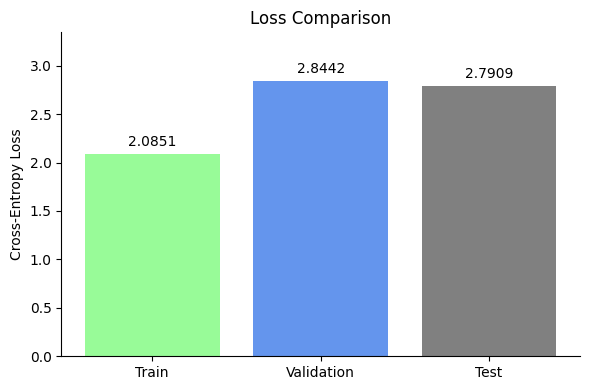

In [32]:
import matplotlib.pyplot as plt

# Loss values
train_loss = 2.0851
val_loss = 2.8442
test_loss = 2.7909

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(
    ['Train', 'Validation', 'Test'],
    [train_loss, val_loss, test_loss],
    color=['palegreen', 'cornflowerblue', 'gray']
)

ax.set_title('Loss Comparison')
ax.set_ylabel('Cross-Entropy Loss')
ax.set_ylim(0, max(val_loss, test_loss) + 0.5)

# Remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, f"{yval:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

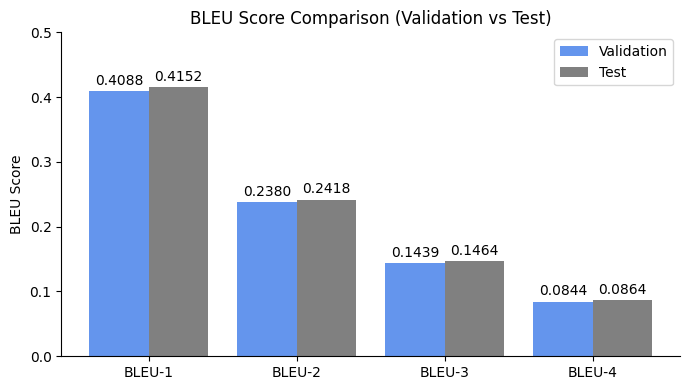

In [33]:
# BLEU scores
bleu_val = [0.4088, 0.2380, 0.1439, 0.0844]
bleu_test = [0.4152, 0.2418, 0.1464, 0.0864]
bleu_labels = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']
x = range(len(bleu_labels))

# Plot
fig, ax = plt.subplots(figsize=(7, 4))
ax.bar([i - 0.2 for i in x], bleu_val, width=0.4, label='Validation', color='cornflowerblue')
ax.bar([i + 0.2 for i in x], bleu_test, width=0.4, label='Test', color='gray')

ax.set_xticks(x)
ax.set_xticklabels(bleu_labels)
ax.set_ylabel('BLEU Score')
ax.set_title('BLEU Score Comparison (Validation vs Test)')
ax.set_ylim(0, 0.5)
ax.legend()

# Remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate bars
for i, (v, t) in enumerate(zip(bleu_val, bleu_test)):
    ax.text(i - 0.2, v + 0.01, f"{v:.4f}", ha='center')
    ax.text(i + 0.2, t + 0.01, f"{t:.4f}", ha='center')

plt.tight_layout()
plt.show()

In [55]:
# Load idx2word mapping
with open("../data/processed/idx2word.json", "r") as f:
    idx2word = json.load(f)

# Make sure keys are integers (JSON stores them as strings)
idx2word = {int(k): v for k, v in idx2word.items()}



In [52]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import os

def decode_caption(indices, idx2word):
    words = []
    for idx in indices:
        word = idx2word.get(idx, "<unk>")
        if word == "<end>":
            break
        if word not in {"<start>", "<pad>"}:
            words.append(word)
    return ' '.join(words)

def show_prediction_with_original_image(model, test_dataset, word2idx, idx2word, device, image_folder, index=None, save=False, save_prefix="image_caption"):
    model.eval()
    pad_idx = word2idx["<pad>"]
    start_idx = word2idx["<start>"]
    end_idx = word2idx["<end>"]

    if index is None:
        index = random.randint(0, len(test_dataset) - 1)

    # Get sample
    image_tensor, caption_tensor, _ = test_dataset[index]
    image_input = image_tensor.unsqueeze(0).to(device)

    # Predict
    seq = [start_idx]
    for _ in range(20):
        caption_input = torch.tensor(seq).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_input, caption_input)
        next_token = output.argmax(2)[0, -1].item()
        seq.append(next_token)
        if next_token == end_idx:
            break

    pred_caption = decode_caption(seq, idx2word)
    ref_caption = decode_caption(caption_tensor.tolist(), idx2word)

    # Manually get the original image filename
    filename = test_dataset.image_filenames[index]
    original_path = os.path.join(image_folder, filename)
    original_img = Image.open(original_path).convert("RGB")

    # Plot clean image + caption
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(original_img)
    ax.axis('off')
    ax.set_title("Image Captioning", fontsize=14)

    plt.figtext(0.5, 0.01, f"Prediction: {pred_caption}", wrap=True, ha='center', fontsize=10, color='blue')
    plt.figtext(0.5, -0.04, f"Reference: {ref_caption}", wrap=True, ha='center', fontsize=10, color='green')

    if save:
        fname = f"{save_prefix}_{index}.png"
        plt.savefig(fname, bbox_inches='tight', dpi=300)
        print(f"📸 Saved: {fname}")

    plt.show()

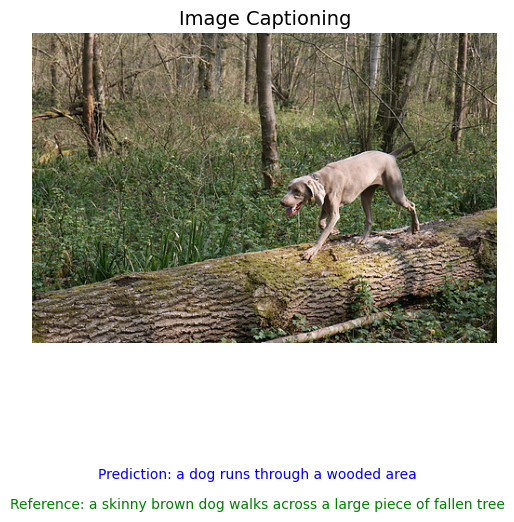

In [53]:
show_prediction_with_original_image(
    model=model,
    test_dataset=test_dataset,
    word2idx=word2idx,
    idx2word=idx2word,
    device=device,
    image_folder="../data/Flicker8k_Dataset"
)

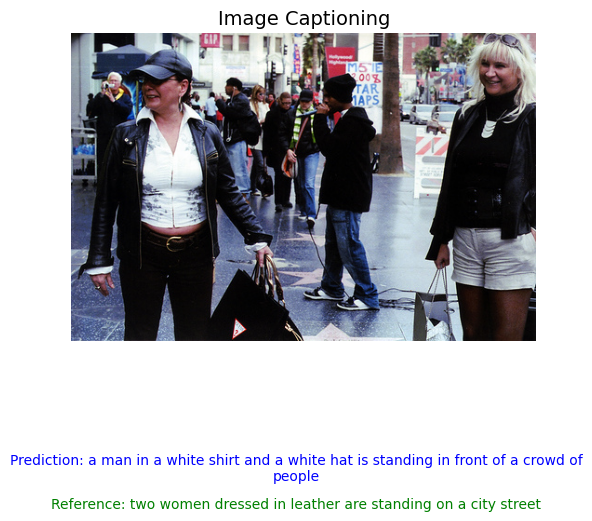

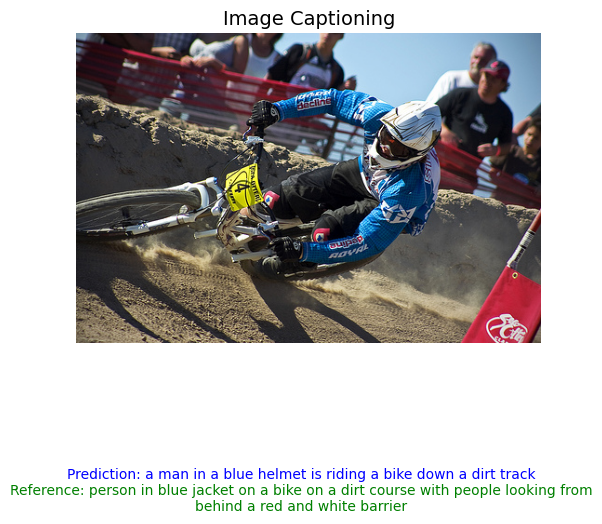

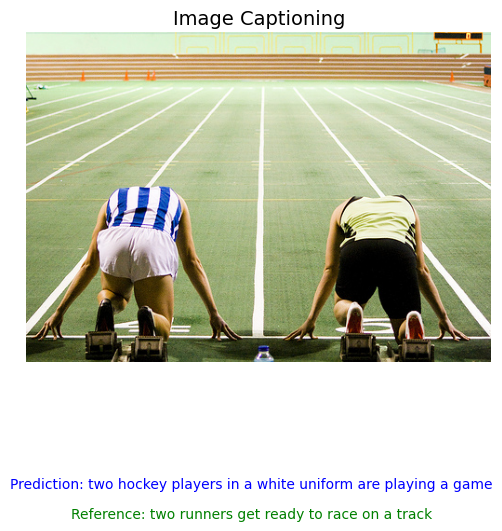

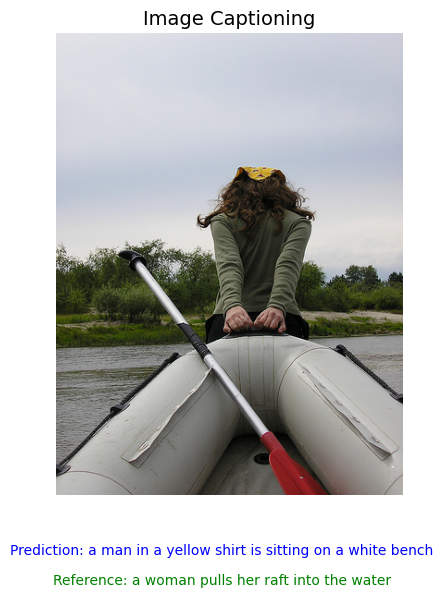

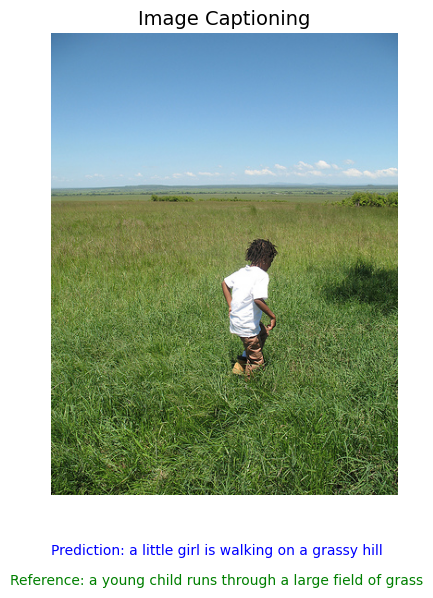

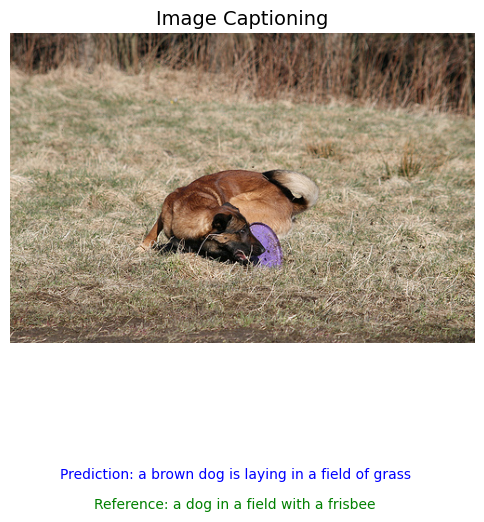

In [54]:
for i in range(6):
    show_prediction_with_original_image(
        model=model,
        test_dataset=test_dataset,
        word2idx=word2idx,
        idx2word=idx2word,
        device=device,
        image_folder="../data/Flicker8k_Dataset",
        index=None,  # random image each time
        save=False   # change to True if you want to save them
    )

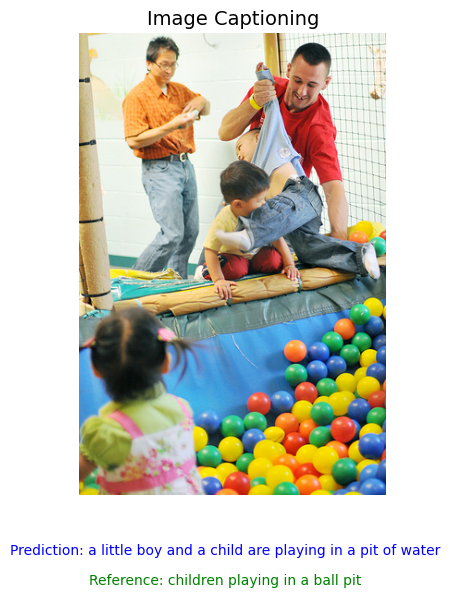

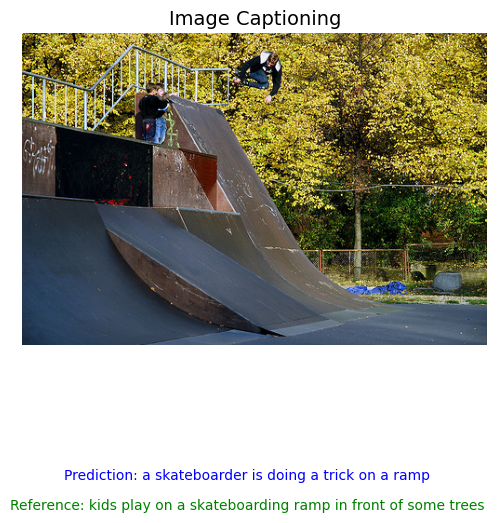

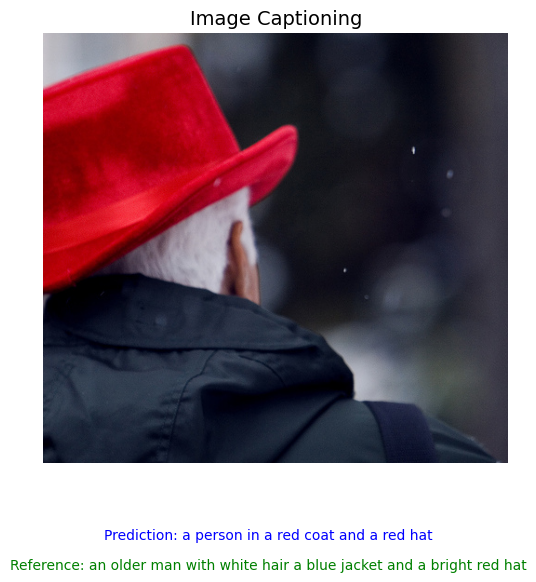

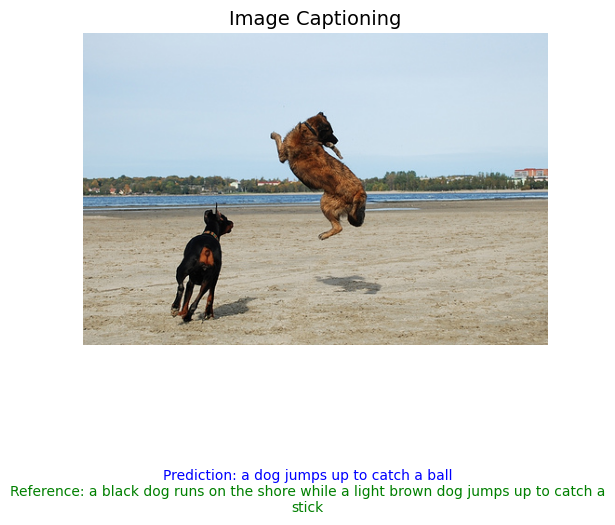

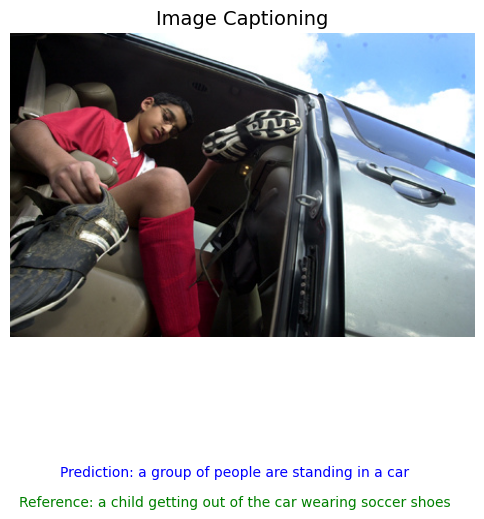

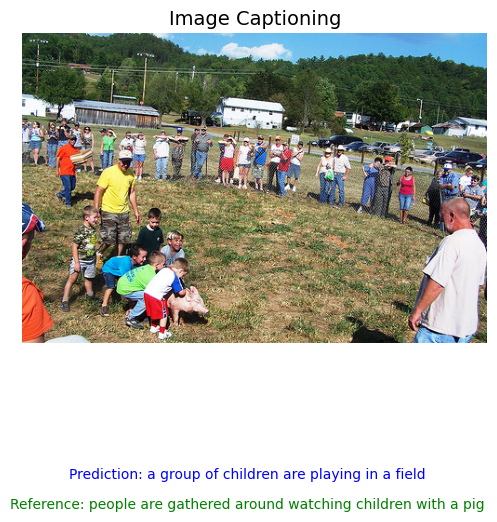

In [64]:
for i in range(6):
    show_prediction_with_original_image(
        model=model,
        test_dataset=test_dataset,
        word2idx=word2idx,
        idx2word=idx2word,
        device=device,
        image_folder="../data/Flicker8k_Dataset",
        index=None,  # random image each time
        save=False   # change to True if you want to save them
    )